<a href="https://colab.research.google.com/github/Sim-Murr/Netflix_DA_Prac/blob/main/Netflix_prac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analyzing Netflix Data**

I'm going to demonstrate how I did some basic analysis on the recently released Netflix dataset of their most watched shows using Pyspark.

I started by importing the modules I may need and creating a spark session.

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=13137f9a396e3a2d139254f6a5a1afbfd4b299f268710220d339bd8c25b6daa2
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import count, desc , col, max, struct, sum, udf, regexp_replace
import matplotlib.pyplot as plt

In [3]:
spark = SparkSession.builder.appName('spark_app').getOrCreate()

First, I imported my dataset and took a look at it. There are only four columns. The release date column isn't needed for the analysis I want to do so I dropped the column.

In [4]:
net_df = spark.read.format('csv').option('inferSchema', True).option('header', True).load('/content/drive/MyDrive/Colab Notebooks/Netflix.csv')
net_df.show()

+--------------------+-------------------+------------+------------+
|               Title|Available Globally?|Release Date|Hours Viewed|
+--------------------+-------------------+------------+------------+
|The Night Agent: ...|                Yes|  2023-03-23| 812,100,000|
|Ginny & Georgia: ...|                Yes|  2023-01-05| 665,100,000|
|The Glory: Season...|                Yes|  2022-12-30| 622,800,000|
| Wednesday: Season 1|                Yes|  2022-11-23| 507,700,000|
|Queen Charlotte: ...|                Yes|  2023-05-04| 503,000,000|
|       You: Season 4|                Yes|  2023-02-09| 440,600,000|
|La Reina del Sur:...|                 No|  2022-12-30| 429,600,000|
|Outer Banks: Seas...|                Yes|  2023-02-23| 402,500,000|
|Ginny & Georgia: ...|                Yes|  2021-02-24| 302,100,000|
|     FUBAR: Season 1|                Yes|  2023-05-25| 266,200,000|
|  Manifest: Season 4|                Yes|  2022-11-04| 262,600,000|
|Kaleidoscope: Lim...|            

In [5]:
net_df = net_df.drop('Release Date')
net_df.show()

+--------------------+-------------------+------------+
|               Title|Available Globally?|Hours Viewed|
+--------------------+-------------------+------------+
|The Night Agent: ...|                Yes| 812,100,000|
|Ginny & Georgia: ...|                Yes| 665,100,000|
|The Glory: Season...|                Yes| 622,800,000|
| Wednesday: Season 1|                Yes| 507,700,000|
|Queen Charlotte: ...|                Yes| 503,000,000|
|       You: Season 4|                Yes| 440,600,000|
|La Reina del Sur:...|                 No| 429,600,000|
|Outer Banks: Seas...|                Yes| 402,500,000|
|Ginny & Georgia: ...|                Yes| 302,100,000|
|     FUBAR: Season 1|                Yes| 266,200,000|
|  Manifest: Season 4|                Yes| 262,600,000|
|Kaleidoscope: Lim...|                Yes| 252,500,000|
|Firefly Lane: Sea...|                Yes| 251,500,000|
|          The Mother|                Yes| 249,900,000|
|Physical: 100: Se...|                Yes| 235,0

I calculated the shape of the dataset for later.

In [6]:
shape = (net_df.count(), len(net_df.columns))
print(shape)

(18214, 3)


I changed the column names of Available Globally? and Hours Viewed to something more manageable with the code.

In [7]:
net_df = net_df.withColumnRenamed('Available Globally?', 'available_globally')
net_df.show()

+--------------------+------------------+------------+
|               Title|available_globally|Hours Viewed|
+--------------------+------------------+------------+
|The Night Agent: ...|               Yes| 812,100,000|
|Ginny & Georgia: ...|               Yes| 665,100,000|
|The Glory: Season...|               Yes| 622,800,000|
| Wednesday: Season 1|               Yes| 507,700,000|
|Queen Charlotte: ...|               Yes| 503,000,000|
|       You: Season 4|               Yes| 440,600,000|
|La Reina del Sur:...|                No| 429,600,000|
|Outer Banks: Seas...|               Yes| 402,500,000|
|Ginny & Georgia: ...|               Yes| 302,100,000|
|     FUBAR: Season 1|               Yes| 266,200,000|
|  Manifest: Season 4|               Yes| 262,600,000|
|Kaleidoscope: Lim...|               Yes| 252,500,000|
|Firefly Lane: Sea...|               Yes| 251,500,000|
|          The Mother|               Yes| 249,900,000|
|Physical: 100: Se...|               Yes| 235,000,000|
|Crash Cou

In [8]:
net_df = net_df.withColumnRenamed('Hours Viewed', 'hours_viewed')
net_df.show()

+--------------------+------------------+------------+
|               Title|available_globally|hours_viewed|
+--------------------+------------------+------------+
|The Night Agent: ...|               Yes| 812,100,000|
|Ginny & Georgia: ...|               Yes| 665,100,000|
|The Glory: Season...|               Yes| 622,800,000|
| Wednesday: Season 1|               Yes| 507,700,000|
|Queen Charlotte: ...|               Yes| 503,000,000|
|       You: Season 4|               Yes| 440,600,000|
|La Reina del Sur:...|                No| 429,600,000|
|Outer Banks: Seas...|               Yes| 402,500,000|
|Ginny & Georgia: ...|               Yes| 302,100,000|
|     FUBAR: Season 1|               Yes| 266,200,000|
|  Manifest: Season 4|               Yes| 262,600,000|
|Kaleidoscope: Lim...|               Yes| 252,500,000|
|Firefly Lane: Sea...|               Yes| 251,500,000|
|          The Mother|               Yes| 249,900,000|
|Physical: 100: Se...|               Yes| 235,000,000|
|Crash Cou

I printed out the schema to check the data types of each column. The hours_viewed column should be integers, so that I can do some calculations later. To do this, I used the regexp_replace function to remove the commas that would get in the way later.

I imported LongType to change the string values into integers since it would give long numbers.

In [9]:
net_df.printSchema()

root
 |-- Title: string (nullable = true)
 |-- available_globally: string (nullable = true)
 |-- hours_viewed: string (nullable = true)



In [10]:
net_df = net_df.withColumn('hours_viewed', regexp_replace(col("hours_viewed"), ",", ""))
net_df.show()

+--------------------+------------------+------------+
|               Title|available_globally|hours_viewed|
+--------------------+------------------+------------+
|The Night Agent: ...|               Yes|   812100000|
|Ginny & Georgia: ...|               Yes|   665100000|
|The Glory: Season...|               Yes|   622800000|
| Wednesday: Season 1|               Yes|   507700000|
|Queen Charlotte: ...|               Yes|   503000000|
|       You: Season 4|               Yes|   440600000|
|La Reina del Sur:...|                No|   429600000|
|Outer Banks: Seas...|               Yes|   402500000|
|Ginny & Georgia: ...|               Yes|   302100000|
|     FUBAR: Season 1|               Yes|   266200000|
|  Manifest: Season 4|               Yes|   262600000|
|Kaleidoscope: Lim...|               Yes|   252500000|
|Firefly Lane: Sea...|               Yes|   251500000|
|          The Mother|               Yes|   249900000|
|Physical: 100: Se...|               Yes|   235000000|
|Crash Cou

In [11]:
from pyspark.sql.types import IntegerType, LongType

In [12]:
net_df_ = net_df.withColumn("hours_viewed", net_df.hours_viewed.cast(LongType()))

Out of curiosity I created 2 dataframes showing which titles were available globally or not.

In [13]:
global_yes = net_df.select('*').filter(net_df.available_globally == 'Yes')
global_yes.show()

+--------------------+------------------+------------+
|               Title|available_globally|hours_viewed|
+--------------------+------------------+------------+
|The Night Agent: ...|               Yes|   812100000|
|Ginny & Georgia: ...|               Yes|   665100000|
|The Glory: Season...|               Yes|   622800000|
| Wednesday: Season 1|               Yes|   507700000|
|Queen Charlotte: ...|               Yes|   503000000|
|       You: Season 4|               Yes|   440600000|
|Outer Banks: Seas...|               Yes|   402500000|
|Ginny & Georgia: ...|               Yes|   302100000|
|     FUBAR: Season 1|               Yes|   266200000|
|  Manifest: Season 4|               Yes|   262600000|
|Kaleidoscope: Lim...|               Yes|   252500000|
|Firefly Lane: Sea...|               Yes|   251500000|
|          The Mother|               Yes|   249900000|
|Physical: 100: Se...|               Yes|   235000000|
|Crash Course in R...|               Yes|   234800000|
|Love Is B

In [14]:
global_no = net_df.select('*').filter(net_df.available_globally == 'No')
global_no.show()

+---------------------+------------------+------------+
|                Title|available_globally|hours_viewed|
+---------------------+------------------+------------+
| La Reina del Sur:...|                No|   429600000|
| Fake Profile: Sea...|                No|   206500000|
| The Surrogacy: Se...|                No|   172400000|
|   Chiquititas (2013)|                No|   162000000|
| New Amsterdam (20...|                No|   153000000|
| Til Money Do Us P...|                No|   152100000|
|Mr. Queen // 철인왕후|                No|   151500000|
|   Manifest: Season 1|                No|   151400000|
| PAW Patrol: Season 6|                No|   149300000|
| Wrong Side of the...|                No|   140100000|
| The Walking Dead:...|                No|   136800000|
|  CoComelon: Season 1|                No|   136200000|
| PAW Patrol: Season 5|                No|   130700000|
| Pasión de Gavilan...|                No|   129200000|
| Breaking Bad: Sea...|                No|   1162000

I used the groupby() and count() functions to see the totals of the titles available globally or not.
There seems to be many more titles that are not globally available than are globally available.

In [15]:
global_yn = net_df.select('available_globally').groupby("available_globally").agg(count('available_globally').alias('count'))
global_yn.show()

+------------------+-----+
|available_globally|count|
+------------------+-----+
|                No|13700|
|               Yes| 4514|
+------------------+-----+



In [33]:
net_df.printSchema()

root
 |-- Title: string (nullable = true)
 |-- available_globally: string (nullable = true)
 |-- hours_viewed: string (nullable = true)



I used groupby() to group my unique values in the available_globally column and then used the aggregate function sum to add up all the hours for each of the available_globally unique values.

 I created a small bar graph using matplotlib for a better visualization. Seems that overall, shows that are available globally were watched more than shows that were not.

In [34]:
sum_global = net_df.select('available_globally', 'hours_viewed').groupby("available_globally").agg(F.sum('hours_viewed').alias('sum'))
sum_global.show()

+------------------+----------+
|available_globally|       sum|
+------------------+----------+
|                No|4.53169E10|
|               Yes|4.81383E10|
+------------------+----------+



<BarContainer object of 2 artists>

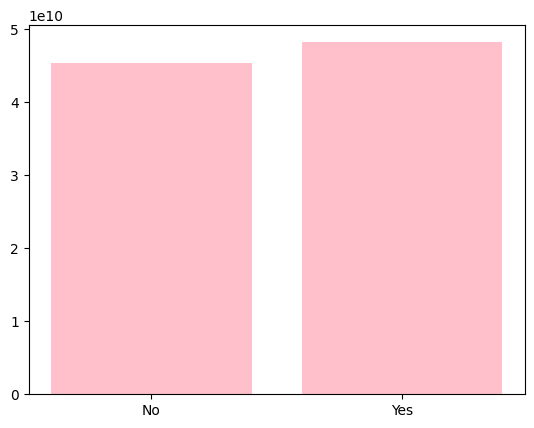

In [18]:
sum_list = sum_global.collect()
labels = [row['available_globally'] for row in sum_list]
counts = [row['sum'] for row in sum_list]
plt.bar(labels, counts, color='pink')

I used the orderBy() function to find the top 10 most viewed shows. The most watched show was a korean romcom called Love to Hate You: Season 1. This show was available globally as well. From this dataframe it seems that the most viewed show that was not available globally was The Blacklist: Season 1.

In [19]:
most_watched = net_df.select('*').orderBy(desc('hours_viewed')).limit(10)
most_watched.show()

+--------------------+------------------+------------+
|               Title|available_globally|hours_viewed|
+--------------------+------------------+------------+
|Love to Hate You:...|               Yes|    99900000|
|The Blacklist: Se...|                No|    99900000|
|Shadow and Bone: ...|               Yes|    99500000|
|The Unbroken Voic...|                No|    99000000|
|Bill Russell: Legend|               Yes|     9900000|
|    Falling Inn Love|               Yes|     9900000|
|  Fugitiva: Season 1|               Yes|     9900000|
|Mighty Little Bhe...|               Yes|     9900000|
|Grace and Frankie...|               Yes|     9900000|
|13 Reasons Why: S...|               Yes|     9900000|
+--------------------+------------------+------------+



In [20]:
most_watched.first()['Title']

'Love to Hate You: Season 1 // 연애대전: 시즌 1'

In [32]:
most_watched.collect()[1][0]

'The Blacklist: Season 1'